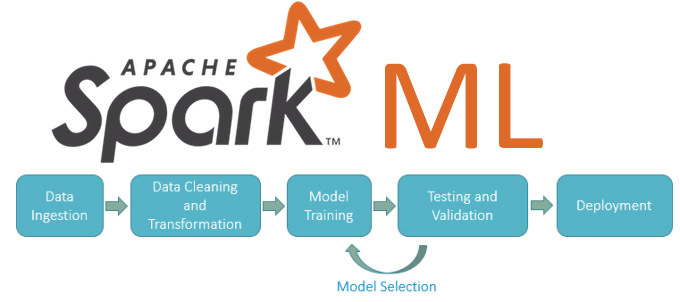

# MLLib

Типичный пайплайн

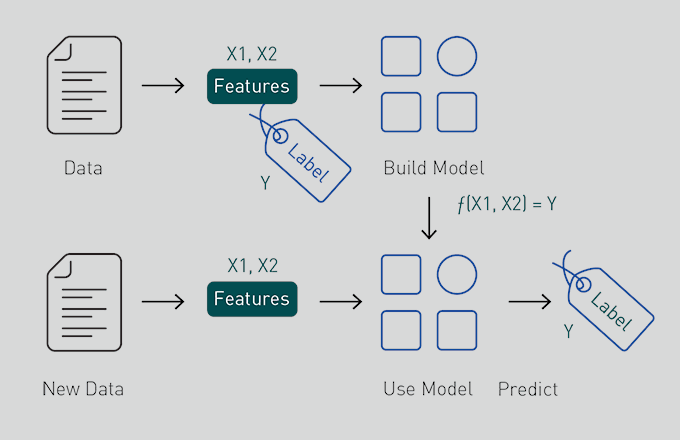

Добавляем streaming
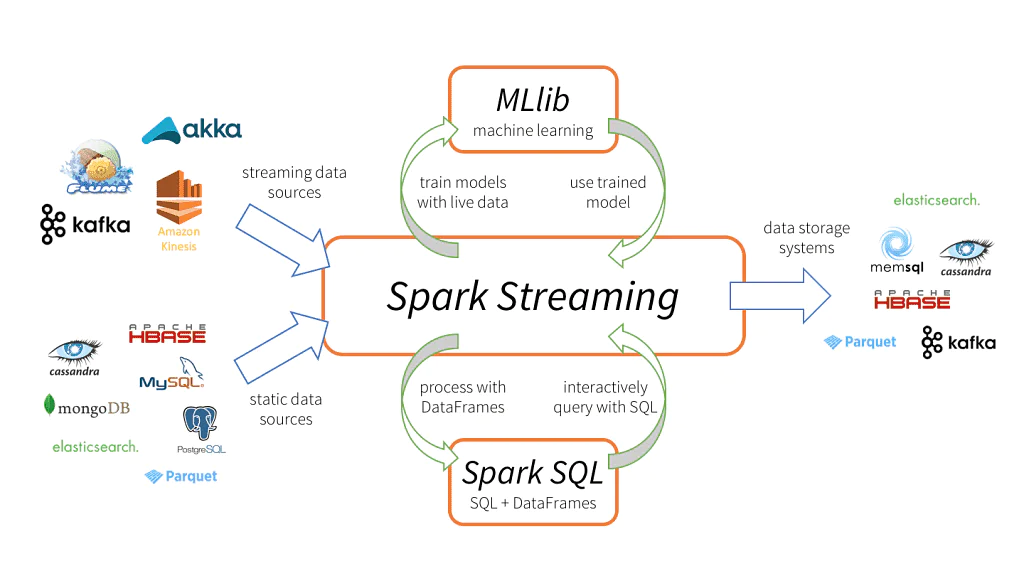

# Настройка окружения

Прежде всего сделайте своё окружение environment.tar.gz (путь должен быть прописан относительно ноутбука)
```
python3 -m venv stream_venv  
source stream_venv/bin/activate  
pip install jupyter venv-pack scikit-learn pandas numpy pyspark  
venv-pack -o environment.tar.gz  
```
Выполнять нужно в терминале:
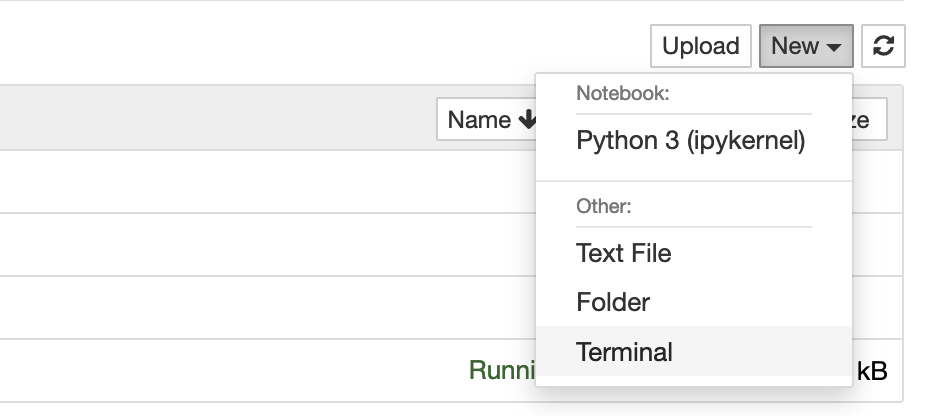

Выберите кернел как на скрине, либо создайте свой из вашего окружения.
Версии питона на драйвере и на нодах должны быть одинаковые
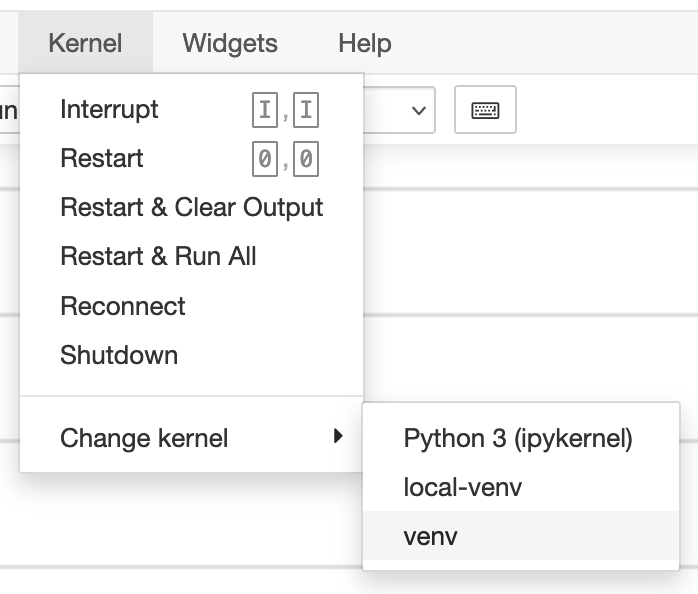

In [ ]:
import os
from pathlib import Path

assert 'environment.tar.gz' in os.listdir(Path('/home', os.environ.get('USER'))), 'Окружение не запаковано'

In [ ]:
# Устанвливаем либы, если не хватает
# !pip install pyspark[sql] findspark --user

# Обучение модели mllib

In [1]:
import sys
import os
from pathlib import Path

import findspark
findspark.init()
findspark.find()

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

#импортируем необходимые библиотеки
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pyspark.sql.functions as sf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

import os


os.environ['PYSPARK_PYTHON'] = 'venv/bin/python'

spark = SparkSession.builder \
    .appName("Spark Streaming") \
    .config("spark.sql.streaming.forceDeleteTempCheckpointLocation", "true") \
    .config("spark.executor.instances", "1") \
    .config("spark.executor.memory", "512mb") \
    .config("spark.yarn.dist.archives", f"{Path('/home', os.environ.get('USER'))}/environment.tar.gz#venv") \
    .getOrCreate()

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/lib/spark/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-23 18:36:09,778 WARN cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Attempted to request executors before the AM has registered!


In [2]:
#загружаем данные формата .csv из path_csv
# https://www.kaggle.com/datasets/unitednations/international-greenhouse-gas-emissions
path_csv = '/var/datasets/greenhouse_gas_inventory_data_data.csv'
data = spark.read.format("csv")\
        .option("header", "true")\
        .option("delimiter", ",")\
        .option("inferSchema", "true")\
        .load(path_csv)

In [4]:
data.show()

+---------------+----+----------------+--------------------+
|country_or_area|year|           value|            category|
+---------------+----+----------------+--------------------+
|      Australia|2014|393126.946994288|carbon_dioxide_co...|
|      Australia|2013| 396913.93653029|carbon_dioxide_co...|
|      Australia|2012|  406462.8477036|carbon_dioxide_co...|
|      Australia|2011|403705.528313991|carbon_dioxide_co...|
|      Australia|2010|406200.993184341|carbon_dioxide_co...|
|      Australia|2009| 408448.47899963|carbon_dioxide_co...|
|      Australia|2008|404237.828214077|carbon_dioxide_co...|
|      Australia|2007|398816.453543549|carbon_dioxide_co...|
|      Australia|2006|391134.100909449|carbon_dioxide_co...|
|      Australia|2005|385581.132806466|carbon_dioxide_co...|
|      Australia|2004|381519.261592783|carbon_dioxide_co...|
|      Australia|2003|368345.977425107|carbon_dioxide_co...|
|      Australia|2002|361861.387896028|carbon_dioxide_co...|
|      Australia|2001|35

In [3]:
#посмотрим на часть данных
data.show(3, vertical=True, truncate=100)

-RECORD 0---------------------------------------------------------------------------------------------------------------
 country_or_area | Australia                                                                                            
 year            | 2014                                                                                                 
 value           | 393126.946994288                                                                                     
 category        | carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co... 
-RECORD 1---------------------------------------------------------------------------------------------------------------
 country_or_area | Australia                                                                                            
 year            | 2013                                                                                                 
 value           | 396913.936530

In [5]:
data.printSchema()

root
 |-- country_or_area: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- value: double (nullable = true)
 |-- category: string (nullable = true)



In [9]:
# value - это зависимая и предсказываемая переменная - метка
stages = []
label_stringIdx = StringIndexer(inputCol='value', outputCol='label', handleInvalid='keep')
stages += [label_stringIdx]

# зависит от категориаьных колонок: страны и категории загрязнения
categoricalColumns = ['country_or_area', 'category']
for categoricalCol in categoricalColumns:
    #преобразование категориальных колонок в бинарные вектора благодаря строковому преобразователю
    stringIndexer = StringIndexer(inputCol = categoricalCol,
                                  outputCol = categoricalCol + 'Index',
                                  handleInvalid = 'keep')
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol=categoricalCol + "classVec")
    stages += [stringIndexer, encoder]

# зависит от численной колонки: года
numericCols = ['year']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
# преобразование нескольких колонок в вектор-колонку - признаки
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
# В итоге у нас колонка year + колонки, показывающие к какой категории или стране относится value

In [10]:
#делим данные на обучающую и тестовую выборки (30% тестовая)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

#тренируем модель (градиентного регрессионого дерева бустинга)
gbt = GBTRegressor(labelCol="label", featuresCol="features", maxIter=10)
stages += [gbt]

# задаем план stages для обучения модели 
pipeline = Pipeline(stages=stages)

In [11]:
# тренируем модель
model = pipeline.fit(trainingData)

# делаем предсказания на тестовой выборке
predictions = model.transform(testData)

In [12]:
predictions.show()

+---------------+----+----------------+--------------------+------+--------------------+-----------------------+-------------+----------------+--------------------+------------------+
|country_or_area|year|           value|            category| label|country_or_areaIndex|country_or_areaclassVec|categoryIndex|categoryclassVec|            features|        prediction|
+---------------+----+----------------+--------------------+------+--------------------+-----------------------+-------------+----------------+--------------------+------------------+
|      Australia|1990|211.018511442384|sulphur_hexafluor...|5554.0|                25.0|        (43,[25],[1.0])|          4.0|  (10,[4],[1.0])|(54,[25,47,53],[1...|2340.9470842411283|
|      Australia|1990|4607.01291909928|perfluorocarbons_...|5554.0|                25.0|        (43,[25],[1.0])|          7.0|  (10,[7],[1.0])|(54,[25,50,53],[1...| 2641.184565220859|
|      Australia|1990|118768.837813046|methane_ch4_emiss...|5554.0|             

In [13]:
# сохраняем модель, именно model, а не pipeline
model.write().overwrite().save('model/gbtregr_model')

In [14]:
!hdfs dfs -ls model/

Found 1 items
drwxr-xr-x   - jupyter-admin hadoop          0 2022-05-23 18:39 model/gbtregr_model


## Streaming

In [15]:
# Вспомогательные функции
def create_parquet_sink(df, file_name):
    return df \
            .writeStream \
            .format("csv") \
            .option("path", "/tmp/output/{f}".format(f=file_name)) \
            .option("checkpointLocation", "/tmp/chk/{f}".format(f=file_name)) \
            .trigger(processingTime="5 seconds")

def kill_all():
    streams = SparkSession.builder.getOrCreate().streams.active
    if streams:
        for stream in streams:
            desc = stream.lastProgress["sources"][0]["description"]
            stream.stop()
            print("Stopped {s}".format(s=desc))

In [16]:
# Загружаем обученную модель
load_model = PipelineModel.load('model/gbtregr_model')

In [4]:
!hdfs dfs -mkdir greenhouse_gas_inventory_data_data
!hdfs dfs -copyFromLocal greenhouse_gas_inventory_data_data.csv greenhouse_gas_inventory_data_data/

mkdir: `greenhouse_gas_inventory_data_data': File exists
copyFromLocal: `greenhouse_gas_inventory_data_data/greenhouse_gas_inventory_data_data.csv': File exists


In [17]:
# Создаём стрим

schema = StructType([
    StructField('country_or_area', StringType(), True),
    StructField('year', IntegerType(), True),
    StructField('value', DoubleType(), True),
    StructField('category', StringType(), True)
])

data_stream = spark.readStream\
        .format("csv")\
        .schema(schema)\
        .option("delimiter", ",")\
        .option('maxFilesPerTrigger', '1') \
        .option('path', 'greenhouse_gas_inventory_data_data/*') \
        .load()

# Проверяем, что это стрим
data_stream.isStreaming

True

In [18]:
load_model.transform(data_stream).select('year', 'country_or_area', 'prediction')

DataFrame[year: int, country_or_area: string, prediction: double]

In [22]:
#  если мы записываем csv, то нужно оставить только стандартные типы ( csv списки и вектора не поддерживает )
# Так же удаляем nans
create_parquet_sink(
    load_model.transform(data_stream.dropna()).select('year', 'country_or_area', 'prediction'), 
    'prediction').start()

In [23]:
# ждём 5 секунд и останавливаем поток
kill_all()

Stopped FileStreamSource[hdfs://rc1a-dataproc-m-hkgx6juek72rytqo.mdb.yandexcloud.net/user/jupyter-admin/greenhouse_gas_inventory_data_data/*]


In [25]:
#  Результат
spark.read.csv('/tmp/output/prediction').show()

+----+---------+------------------+
| _c0|      _c1|               _c2|
+----+---------+------------------+
|2014|Australia|2903.6560070478226|
|2013|Australia|2903.6560070478226|
|2012|Australia|2903.6560070478226|
|2011|Australia|2903.6560070478226|
|2010|Australia|2903.6560070478226|
|2009|Australia|2903.6560070478226|
|2008|Australia|2903.6560070478226|
|2007|Australia|2903.6560070478226|
|2006|Australia|2903.6560070478226|
|2005|Australia|2903.6560070478226|
|2004|Australia|2869.8715293154805|
|2003|Australia|2869.8715293154805|
|2002|Australia|2838.1726431289444|
|2001|Australia|2838.1726431289444|
|2000|Australia|2838.1726431289444|
|1999|Australia|2838.1726431289444|
|1998|Australia|2838.1726431289444|
|1997|Australia|2838.1726431289444|
|1996|Australia|2838.1726431289444|
|1995|Australia| 2844.449118687324|
+----+---------+------------------+
only showing top 20 rows



В чём отличие от обычного процесса:
1. Требуется более высокая скорость:
    a. Скос данных  
    b. maxOffsetPerTrigger  
	c. minPartitions  
2. Потеря данных:
    a. graceful shutdown (query.stop(), query.awaitTermination())  
3. Мониторинг

    minPartitions — Минимум партиций из стрима.

** по умолчанию 1 к 1, сколько партиций в топике столько же в спарке.

** Если у на 3 партиции в кафке, а minPartitions будет 6, то на стороне спарка, каждая партиция разобётся на две.

** Таким образом мы косвенно контролируем кол-во и объём партицый и получаем больше параллелизма.

    maxOffsetsPerTrigger — Максимальное кол-во сообщений.

** Контроль размера батча, который мы обрабатываем

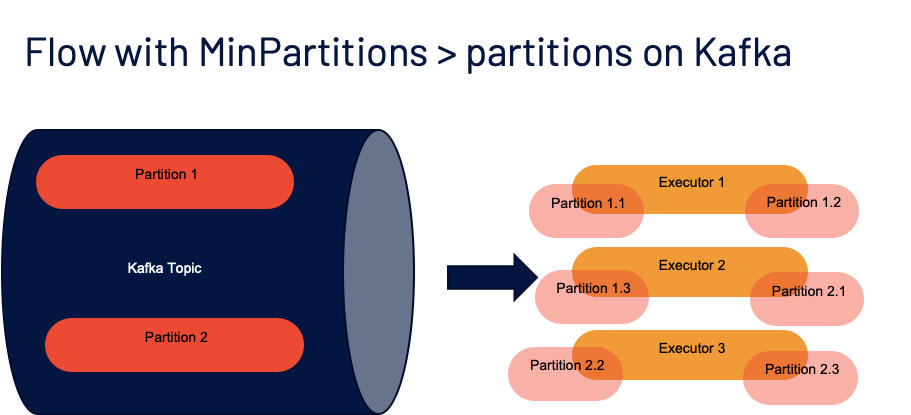

так же в новой версии спарка есть minOffsetsPerTrigger